# Single-rotor Noise &ndash; Example and Validation

In [1]:
using Revise

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /home/edoalvar/.julia/packages/Revise/ucYAZ/src/Revise.jl:1331


In [2]:
import FLOWUnsteady

# Aliases
uns = FLOWUnsteady
vpm = FLOWUnsteady.vpm
vlm = FLOWUnsteady.vlm
noise = FLOWUnsteady.noise
gt = FLOWUnsteady.gt

# Create temps folder
if ispath("temps")==false; mkdir("temps"); end;

┌ Info: Precompiling FLOWUnsteady [b491798d-ac6e-455f-a27c-49c10bb0a666]
└ @ Base loading.jl:1260
┌ Warning: Package FLOWUnsteady does not have FLOWVPM in its dependencies:
│ - If you have FLOWUnsteady checked out for development and have
│   added FLOWVPM as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FLOWUnsteady
└ Loading FLOWVPM into FLOWUnsteady from project dependency, future warnings for FLOWUnsteady are suppressed.


This notebook contains an example on how to run an aeroacoustic analysis using FLOWUnsteady coupled with PSU-WOPWOP. In here we show how to generate the aerodynamic solution, how to format the solution for PSU-WOPWOP (PSW, for short), run PSW to get tonal noise, use BPM to get broadband noise, and how the outputs can be visualized in Paraview and processed in a variety of forms.

We then compare results with experimental acoustic data from the literature.

## Test Case

The example shown here consists of an isolated 9.4in-diameter rotor in hover. The rotor and configuration matches the DJI 9443 propeller described in Zawodny, N. S., & Boyd, Jr., D. D., (2016), *Acoustic Characterization and Prediction of Representative, Small-scale Rotary-wing Unmanned Aircraft System Components*. See also the results shown in Alvarez, E. J., Schenk, A., Critchfield, T., and Ning, A., (2020), *Rotor-on-Rotor Aeroacoustic Interactions of Multirotor in Hover*.

This is what the actual DJI 9443 rotor looks like:

<img src="img/dji9443_00.png" alt="Pic here" width="300px">

This is the aeroacoustic output of FLOWUnsteady:

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWUnsteady/dji9443_ccblade01_1.gif" alt="Vid here" width="700px">

## *Step 1:* Aerodynamic Solution

In this step we use any of the aerodynamic solvers in FLOWUnsteady to generate the aerodynamic loading and rotor geometry. In this example we are using the quasi-steady solver that uses blade-element momentum theory (BEMT) to generate the aerodynamic solution shown below. The BEMT solution predicts a $C_T$ of 0.0734, meanwhile Zawodny et al. reports an experimental $C_T$ of 0.0719. This results in an **excellent agreement, with a discrepancy of only 2\% between FLOWUnsteady and the experimental $C_T$**.

This is what the aerodynamic solution looks like coming out of FLOWUnsteady:

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWUnsteady/dji9443_single_bemnoise_00_ww_1.gif" alt="Vid here" width="900px">

	Generating geometry...
	Generating airfoil data...
		Running XFOIL on airfoil 1 out of 7... done.
		Running XFOIL on airfoil 2 out of 7... done.
		Running XFOIL on airfoil 3 out of 7... done.
		Running XFOIL on airfoil 4 out of 7... done.
		Running XFOIL on airfoil 5 out of 7... done.
		Running XFOIL on airfoil 6 out of 7... done.
		Running XFOIL on airfoil 7 out of 7... done.
	Generating FLOWVLM Rotor...
-------------------------------------------------------------------------

	SOLVER SETTINGS
		  maxparticles----> 808
		   formulation----> formulation_sphere_momentum
		       viscous----> FLOWVPM.Inviscid{Float64}(0.0)
		        kernel----> gaussianerf
		            UJ----> UJ_fmm
		          Uinf----> (Symbol("*userfunction"), "#117")
		      sgsmodel----> sgs_none
		   integration----> rungekutta3
		    transposed----> true
		    relaxation----> pedrizzetti
		         relax----> true
		          rlxf----> 0.3
		           fmm----> FLOWVPM.FMM(4, 50, 0.4, 0.5)


/home/edoalvar/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)



	SIMULATION SETTINGS
		dt:			9.259259259259259e-5
		nsteps_relax:		1
		Runtime function:	Yes
		Static particles:	Yes
		nsteps_save:		1

-------------------------------------------------------------------------
*************************************************************************
START temps/example_dji9443_00/singlerotor_pfield
	2021-01-27T16:26:24.993
*************************************************************************
	Time step 0 out of 2	Particles: 0
*************************************************************************

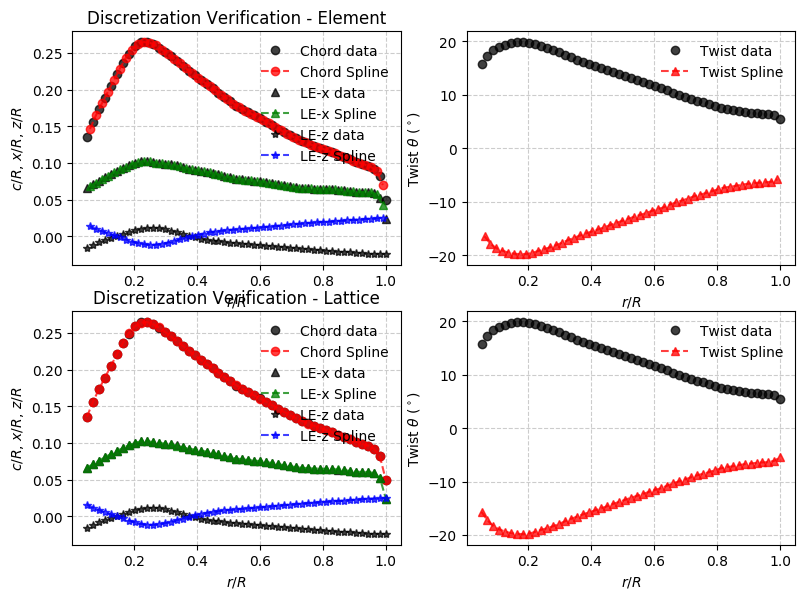

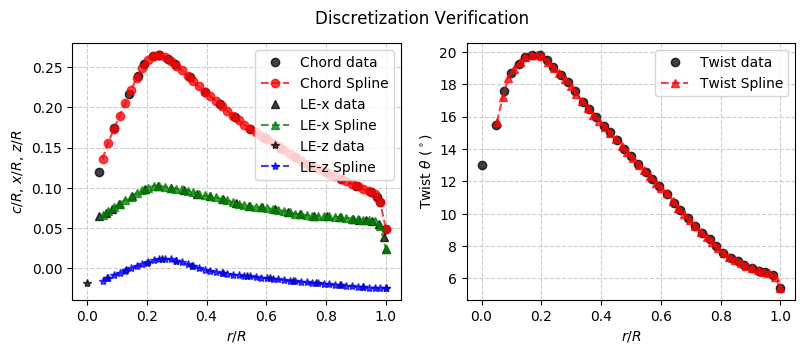

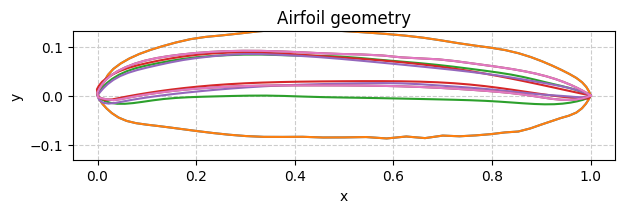

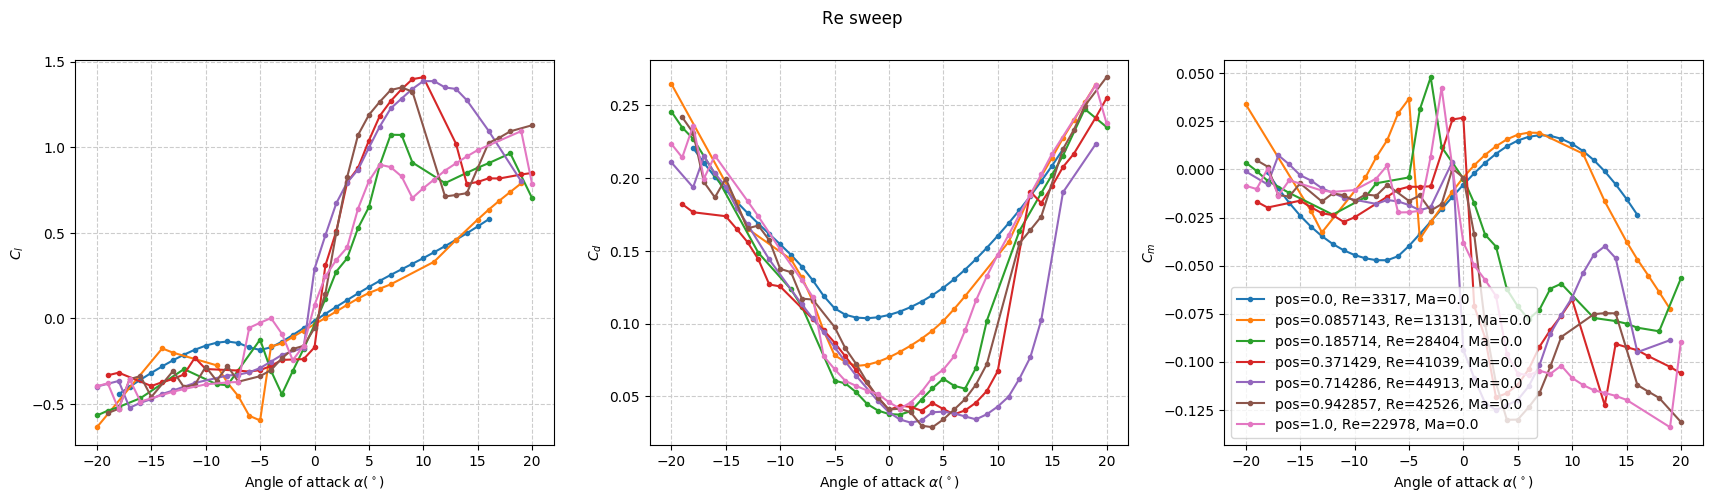

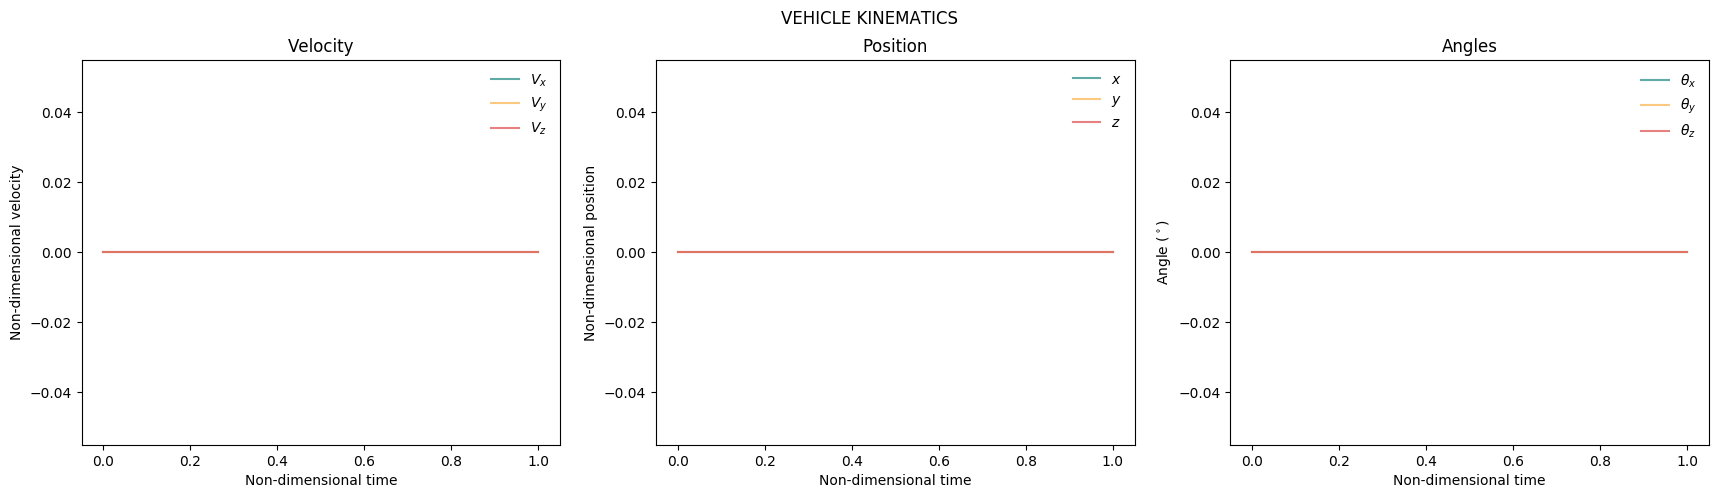

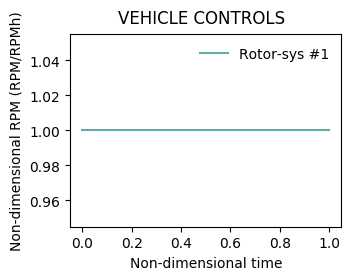

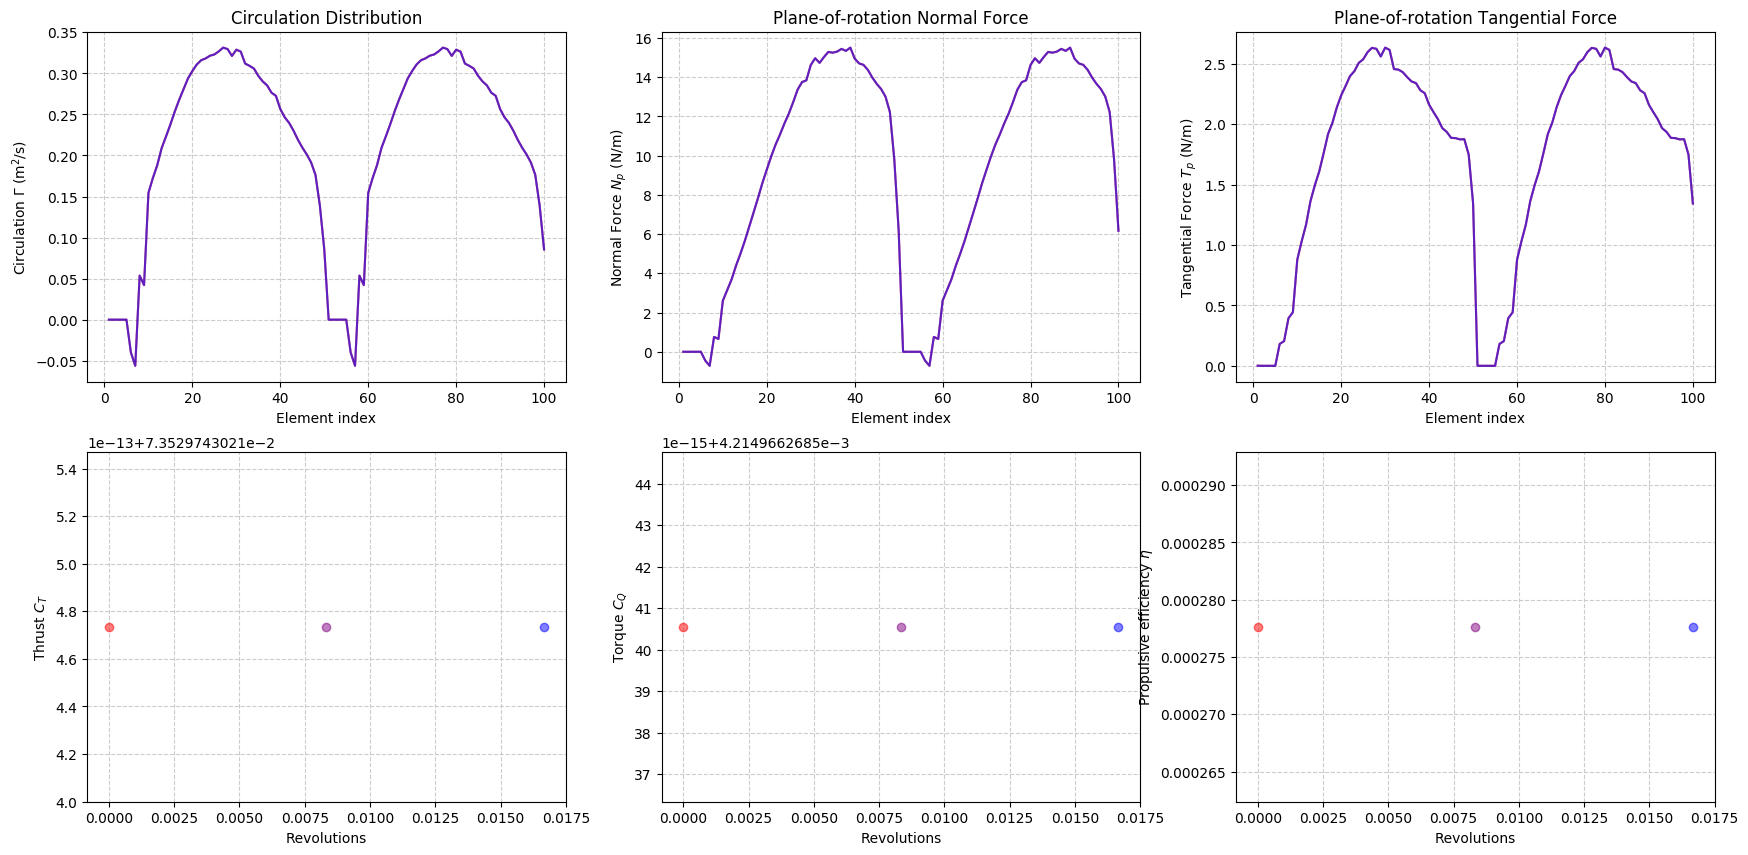


END temps/example_dji9443_00/singlerotor_pfield
	2021-01-27T16:26:40.455
*************************************************************************
ELAPSED TIME: 0 hours 0 minutes 15 seconds


In [5]:
save_path       = "temps/example_dji9443_00/"  # Where to save the simulation


# ------------ PARAMETERS --------------------------------------------------
# Rotor geometry
rotor_file      = "DJI9443.csv"        # Rotor geometry
data_path       = uns.def_data_path    # Path to rotor database
pitch           = 0.0                  # (deg) collective pitch of blades
n               = 50                   # Number of blade elements
CW              = true                 # Clock-wise rotation
xfoil           = true                 # Whether to run XFOIL


# Read radius of this rotor and number of blades
R, B            = uns.read_rotor(rotor_file; data_path=data_path)[[1,3]]

# Simulation parameters
RPM             = 5400                 # RPM
J               = 0.0001               # Advance ratio Vinf/(nD)
rho             = 1.071778             # (kg/m^3) air density
mu              = 1.85508e-5           # (kg/ms) air dynamic viscosity
speedofsound    = 342.35               # (m/s) speed of sound
ReD             = 2*pi*RPM/60*R * rho/mu * 2*R   # Diameter-based Reynolds number

magVinf         = J*RPM/60*(2*R)
Vinf(X,t)       = magVinf*[1.0, 0, 0]  # (m/s) freestream velocity

# Aerodynamic solver
# VehicleType   = uns.UVLMVehicle      # Unsteady solver (VPM)
VehicleType     = uns.QVLMVehicle      # Quasi-steady solver (BEMT)

# Solver parameters
const_solution  = VehicleType==uns.QVLMVehicle # Whether to generate a constant aero solution
nrevs           = 10                   # Number of revolutions in simulation
nsteps_per_rev  = 120                  # Time steps per revolution
nsteps          = const_solution ? 2 : nrevs*nsteps_per_rev # Number of time steps
ttot            = nsteps/nsteps_per_rev / (RPM/60)          # (s) total simulation time

# (Unsteady solver settings, if used)
p_per_step      = 2                    # Sheds per time step
lambda          = 2.125                # Core overlap
overwrite_sigma = lambda * 2*pi*R/(nsteps_per_rev*p_per_step) # Smoothing core size
surf_sigma      = R/10                 # Smoothing radius of lifting surface
vlm_sigma       = surf_sigma           # Smoothing radius of VLM
shed_unsteady   = true                 # Shed particles from unsteady loading
                                       # Max particles for memory pre-allocation
max_particles   = ((2*n+1)*B)*nsteps*p_per_step

# OUTPUT OPTIONS
run_name        = "singlerotor"
nsteps_save     = 1                    # Save vtks every this many steps
save_wopwopin   = true                 # Generate inputs for PSU-WOPWOP
prompt          = false                # Whether to promp the user
verbose         = true                 # Enable verbose
plot_disc       = true                 # Plot blade discretization for debugging




# ------------ SIMULATION SETUP --------------------------------------------
# Generate rotor
rotor = uns.generate_rotor(rotor_file; pitch=pitch,
                                        n=n, CW=CW, ReD=ReD, altReD=[RPM, J, mu/rho],
                                        verbose=verbose, xfoil=xfoil,
                                        data_path=data_path,
                                        plot_disc=plot_disc)

# ----- VEHICLE DEFINITION
# System of all FLOWVLM objects
system = vlm.WingSystem()
vlm.addwing(system, "Rotor1", rotor)

# Systems of rotors
rotors = vlm.Rotor[rotor]   # Defining this rotor as its own system
rotor_systems = (rotors,)

# Wake-shedding system (don't include the rotor if quasi-steady vehicle)
wake_system = vlm.WingSystem()

if VehicleType != uns.QVLMVehicle
    vlm.addwing(wake_system, "Rotor1", rotor)
else
    # Mute colinear warnings. This is needed since the quasi-steady solver
    #   will probe induced velocities at the lifting line of the blade
    uns.vlm.VLMSolver._mute_warning(true)
end

# Define vehicle object
vehicle = VehicleType(   system;
                            rotor_systems=rotor_systems,
                            wake_system=wake_system
                         )


# ----- MANEUVER DEFINITION
RPM_fun(t) = 1.0                # RPM (normalized by reference RPM) as a
                                # function of normalized time
angle = ()                      # Angle of each tilting system (none in this case)
sysRPM = (RPM_fun, )            # RPM of each rotor system
Vvehicle(t) = zeros(3)          # Translational velocity of vehicle over Vcruise
anglevehicle(t) = zeros(3)      # (deg) angle of the vehicle

# Define Maneuver object
maneuver = uns.KinematicManeuver(angle, sysRPM, Vvehicle, anglevehicle)

# Plot maneuver path and controls
uns.plot_maneuver(maneuver; vis_nsteps=nsteps)


# ----- SIMULATION DEFINITION
RPMref = RPM
Vref = 0.0

tinit = 0.0                                  # (s) initial time
Vinit = Vref*maneuver.Vvehicle(tinit/ttot)   # (m/s) initial vehicle velocity
angle1 = maneuver.anglevehicle(tinit/ttot)   # (rad/s) initial vehicle angular velocity
angle2 = maneuver.anglevehicle(tinit/ttot + 1e-12)
Winit = pi/180 * (angle2-angle1)/(ttot*1e-12)

simulation = uns.Simulation(vehicle, maneuver, Vref, RPMref, ttot;
                                            Vinit=Vinit, Winit=Winit, t=tinit)


# ----- MONITOR DEFINITION
monitor = uns.generate_monitor_rotors( rotors, J, rho, RPM, nsteps;
                                    t_scale=RPM/60,        # Time scaling factor for plots
                                    t_lbl="Revolutions",   # x-axis label
                                    # OUTPUT OPTIONS
                                    save_path=save_path,
                                    run_name="rotor",
                                    figname="monitor_rotor",
                                    disp_conv=verbose,)


# ------------ RUN SIMULATION ----------------------------------------------
pfield = uns.run_simulation(simulation, nsteps;
                                  # SIMULATION OPTIONS
                                  Vinf=Vinf,
                                  rho=rho,
                                  mu=mu,
                                  sound_spd=speedofsound,
                                  # SOLVERS OPTIONS
                                  p_per_step=p_per_step,
                                  overwrite_sigma=overwrite_sigma,
                                  vlm_sigma=vlm_sigma,
                                  surf_sigma=surf_sigma,
                                  max_particles=max_particles,
                                  shed_unsteady=shed_unsteady,
                                  extra_runtime_function=monitor,
                                  # OUTPUT OPTIONS
                                  save_path=save_path,
                                  run_name=run_name,
                                  nsteps_save=nsteps_save,
                                  save_wopwopin=save_wopwopin,
                                  prompt=prompt,
                                  verbose=verbose,
                             );     

In [4]:
1e-13 + 7.352974e-2

0.0735297400001

## *Step 2:* Aeroacoustic Solution &ndash; Tonal Noise

In this step, we feed the aerodynamic solution to PSU-WOPWOP to obtain the tonal noise in a circular array of microphones located at 1.905 m from the rotor hub as shown below.

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWUnsteady//ransnoise_dji9443_single_new01_00_2.gif" alt="Vid here" width="500px">

In [8]:
# Path from where to read aerodynamic solution
read_path       = pwd()*"/temps/example_dji9443_00/"
# Path where to save PSU-WOPWOP's outputs
save_path       = "temps/example_dji9443_00_psw00/"
# Path to PSU-WOPWOP binary (not included in FLOWUnsteady)
wopwopbin       = "/home/edoalvar/Dropbox/FLOWResearch/OtherCodes/PSU-WOPWOP_v3.4.3_B3385/wopwop3_serial"
# Run name (prefix of rotor files to read)
run_name        = "singlerotor"

# ------------ PARAMETERS --------------------------------------------------
# NOTE: Make sure that these parameters match what was used in the 
#       aerodynamic solution.

# Rotor geometry
rotor_file      = "DJI9443.csv"        # Rotor geometry
data_path       = uns.def_data_path    # Path to rotor database

# Read radius of this rotor and number of blades
R, B            = uns.read_rotor(rotor_file; data_path=data_path)[[1,3]]

rotorsystems    = [[B]]                # rotorsystems[si][ri] is the number of blades of the ri-th rotor in the si-th system

# Simulation parameters
RPM             = 5400                 # RPM is just a reference value to go from nrevs to simulation time
rho             = 1.071778             # (kg/m^3) air density
speedofsound    = 342.35               # (m/s) speed of sound

# Solver parameters
ww_nrevs        = 9                    # Number of revolutions in PSU-WOPWOP
ww_nsteps_per_rev = 120                # Number of steps per revolution in PSU-WOPWOP
num_min         = 1                    # Start reading aero files from this number
periodic        = const_solution       # Periodic aerodynamic solution
const_geometry  = const_solution       # Whether to run PSW on constant geometry from num_min
CW              = CW                   # Clock-wise rotation of constant geometry
highpass        = 0*0.0001             # High pass filter. Set to >0 to get rid of 0th freq in OASPL

# Observer definition: Circular array of microphones
sph_R           = 1.905                # (m) radial distance from rotor hub
sph_nR          = 0
sph_nphi        = 0
sph_ntht        = 72                   # Number of microphones
sph_thtmin      = 0                    # (deg) first microphone's angle
sph_thtmax      = 360                  # (deg) last microphone's angle
sph_phimax      = 180
sph_rotation    = [90, 0, 0]           # Rotation of grid of microphones
obs_name = "circle_mic_array"          # Observer file name

# Observer definition: Single microphone
Rmic = 1.905                           # (m) radial distance from rotor hub
anglemic = 90*pi/180                   # (rad) microphone angle from plane of rotation (- below, + above)
                                       # 0deg is at the plane of rotation, 90deg is upstream
microphoneX = nothing                  # Comment and uncomment this to switch from array to single microphone
# microphoneX = Rmic*[-sin(anglemic), cos(anglemic), 0]


# ------------ RUN PSU-WOPWOP ----------------------------------------------
uns.run_noise_wopwop(read_path, run_name, RPM, rho, speedofsound, rotorsystems, 
                        ww_nrevs, ww_nsteps_per_rev, save_path, wopwopbin;
                        # ---------- OBSERVERS -------------------------
                        sph_R=sph_R,
                        sph_nR=sph_nR, sph_ntht=sph_ntht,
                        sph_nphi=sph_nphi, sph_phimax=sph_phimax,
                        sph_rotation=sph_rotation,
                        sph_thtmin=sph_thtmin, sph_thtmax=sph_thtmax,
                        microphoneX=microphoneX,
                        # ---------- SIMULATION OPTIONS ----------------
                        periodic=periodic,
                        # ---------- INPUT OPTIONS ---------------------
                        num_min=num_min,
                        const_geometry=const_geometry,
                        axisrot="automatic",
                        CW=CW,
                        highpass=highpass,
                        # ---------- OUTPUT OPTIONS --------------------
                        verbose=true, v_lvl=0,
                        prompt=false, debug_paraview=false,
                        debuglvl=0,                     # WW debug level
                        observerf_name="observergrid",  # .xyz file with observer grid
                        case_name="runcase",            # Name of case to create and run
                        );

Creating work directory...
Creating spherical observer grid...


┌ Warning: axisrot set to "automatic"; defaulting to [1, 0, 0].
└ @ FLOWUnsteady /home/edoalvar/Dropbox/FLOWResearch/FLOWCodes/FLOWUnsteady/src/FLOWUnsteady_noise_wopwop.jl:75


Generating WOPWOP geometry files... (reading num range 1:1)
	file singlerotor_Rotor1_Blade1_loft...
	file singlerotor_Rotor1_Blade2_loft...
	file singlerotor_Sys1_Rotor1_Blade1_compact...
	file singlerotor_Sys1_Rotor1_Blade2_compact...
Generating WOPWOP loading files...
Running PSU-WOPWOP...
********** PSU-WOPWOP Version 3.4.3 (PSU Internal Build 3385 [locally modified]) ***********
  
 *****************************************************************
 ***  Reading case file: ./runcase/runcase.nam
 *****************************************************************
 Environment Created
 Case Setup Time =   5.299999989802018E-003
 Computing noise for ObserverContainer
 Calculating results for ObserverContainer
 Environment Destroyed.
PSU-WOPWOP is done!


## *Optional Step:* Processing VTKs

When debugging things, I like to convert the PSU-WOPWOP's inputs back to vtk and visualize them in Paraview. This helps verify that we are passing the right things to PSU-WOPWOP. In order to do that, the following lines grab those inputs files that are formated for PSU-WOPWOP and converts them into vtk files.

NOTE: All geometry visualizations in this notebook were generated opening these vtk files in Paraview.

In [9]:
read_path = "temps/example_dji9443_00_psw00/runcase/"         # Path to PSW's input files
save_path = read_path*"../vtks/"                              # Where to save VTK files

# Generate VTK files
vtk_str = noise.save_geomwopwop2vtk(read_path, save_path; prompt=false, verbose_level=0)

# Call Paraview to visualize VTKs
run(`paraview --data=$(vtk_str)`)

println("Generated the following files:\n\t$(vtk_str)")

*************************************************************************
*		READING singlerotor_Rotor1_Blade1_loft.wop
*************************************************************************
*************************************************************************
*		READING singlerotor_Rotor1_Blade2_loft.wop
*************************************************************************
*************************************************************************
*		READING singlerotor_Sys1_Rotor1_Blade1_compact.wop
*************************************************************************
*************************************************************************
*		READING singlerotor_Sys1_Rotor1_Blade2_compact.wop
*************************************************************************
Generated the following files:
	temps/example_dji9443_00_psw00/runcase/../vtks//singlerotor_Rotor1_Blade1_loft_vtkpatch.vtk;singlerotor_Rotor1_Blade2_loft_vtkpatch.vtk;singlerotor_Sys1_Rotor1_Blade1_compact_v

## *Step 3:* Aeroacoustic Solution &ndash; Broadband Noise

In [9]:
# Path where to save BPM's outputs
save_path       = "temps/example_dji9443_00_bpm00/"

# ------------ PARAMETERS --------------------------------------------------
# NOTE: Make sure that these parameters match what was used in the 
#       aerodynamic solution.

# Rotor geometry
rotor_file      = "DJI9443.csv"        # Rotor geometry
data_path       = uns.def_data_path    # Path to rotor database
pitch           = 0.0                  # (deg) collective pitch of blades
n               = 50                   # Number of blade elements
CW              = true                 # Clock-wise rotation


# Read radius of this rotor and number of blades
R, B            = uns.read_rotor(rotor_file; data_path=data_path)[[1,3]]

# Simulation parameters
RPM             = 5400                 # RPM
J               = 0.0001               # Advance ratio Vinf/(nD)
rho             = 1.071778             # (kg/m^3) air density
mu              = 1.85508e-5           # (kg/ms) air dynamic viscosity
speedofsound    = 342.35               # (m/s) speed of sound

magVinf         = J*RPM/60*(2*R)
Vinf(X,t)       = magVinf*[1.0, 0, 0]  # (m/s) freestream velocity

# BPM parameters
noise_correction= 0.65                 # Calibration parameter
TE_thickness    = 16.0                 # (deg) trailing edge thickness
freq_bins       = uns.BPM.default_f    # Frequency bins (default is one-third octave band)

# Observer definition: Circular array of microphones
sph_R           = 1.905                # (m) radial distance from rotor hub
sph_nR          = 0
sph_nphi        = 0
sph_ntht        = 72                   # Number of microphones
sph_thtmin      = 0                    # (deg) first microphone's angle
sph_thtmax      = 360                  # (deg) last microphone's angle
sph_phimax      = 180
sph_rotation    = [90, 0, 0]           # Rotation of grid of microphones

# Observer definition: Single microphone
Rmic = 1.905                           # (m) radial distance from rotor hub
anglemic = 90*pi/180                   # (rad) microphone angle from plane of rotation (- below, + above)
                                       # 0deg is at the plane of rotation, 90deg is upstream
microphoneX = nothing                  # Comment and uncomment this to switch from array to single microphone
# microphoneX = Rmic*[-sin(anglemic), cos(anglemic), 0]

# OUTPUT OPTIONS
prompt          = false                # Whether to promp the user
verbose         = false
plot_disc       = false                # Plot blade discretization for debugging

# ------------ GENERATE GEOMETRY -------------------------------------------
# Generate rotor
rotor = uns.generate_rotor(rotor_file; pitch=pitch,
                                        n=n, CW=CW, ReD=0.0,
                                        verbose=verbose, xfoil=false,
                                        data_path=data_path,
                                        plot_disc=plot_disc)
rotors = vlm.Rotor[rotor]

# ------------ RUN BPM -----------------------------------------------------
uns.run_noise_bpm(rotors, RPM, Vinf, rho, mu, speedofsound,
                                save_path;
                                # ---------- OBSERVERS -------------------------
                                sph_R=sph_R,
                                sph_nR=sph_nR, sph_ntht=sph_ntht,
                                sph_nphi=sph_nphi, sph_phimax=sph_phimax,
                                sph_rotation=sph_rotation,
                                sph_thtmin=sph_thtmin, sph_thtmax=sph_thtmax,
                                microphoneX=microphoneX,
                                # ---------- BPM OPTIONS -----------------------
                                noise_correction=noise_correction,
                                TE_thickness=TE_thickness,
                                freq_bins=freq_bins,
                                # ---------- OUTPUT OPTIONS --------------------
                                prompt=prompt
                                );



Folder temps/example_dji9443_00_bpm00/ already exists. Remove? (y/n) stdin> y


Calculating BPM noise...
	Observer 1 out of 72
	Observer 11 out of 72
	Observer 21 out of 72
	Observer 31 out of 72
	Observer 41 out of 72
	Observer 51 out of 72
	Observer 61 out of 72
	Observer 71 out of 72
	Observer 72 out of 72
BPM calculation is done!


## *Step 4:* Processing and Plotting Results

In this section we process the data to add the tonal and broadband together, and plot the results.

### Read Data

In this cell we read both the tonal and broadband noise solutions that we have previously generated:

In [3]:
# Dataset to read and associated information
dataset_infos = [   # (label, PSW solution, BPM solution, BPM freq bins, line style, color)
                    ("FLOWUnsteady w/BEMT", 
                        "temps/example_dji9443_00_psw00/runcase/", 
                        "temps/example_dji9443_00_bpm00", 
                        "-", "r")
                ]

datasets_psw = Dict()     # Stores PSW data in this dictionary
datasets_bpm = Dict()     # Stores BPM data in this dictionary

# Read datasets and stores them in dictionaries
noise.read_data(dataset_infos; datasets_psw=datasets_psw, datasets_bpm=datasets_bpm)

println("Done!")

************************************************************************
*	Reading dataset temps/example_dji9443_00_psw00/runcase/
************************************************************************
	Reading output file pressure.nam ...
		Found 72x1 grid in WOPWOP output with 1080 time steps.
	Reading output file spl_spectrum.nam ...
		Found 72x1 grid in WOPWOP output with 541 time steps.
	Reading output file OASPLdB.nam ...
		Found 72x1 grid in WOPWOP output with 1 time steps.
	Reading output file OASPLdBA.nam ...
		Found 72x1 grid in WOPWOP output with 1 time steps.
************************************************************************
*	Reading dataset temps/example_dji9443_00_bpm00
************************************************************************
	Reading output file spl_spectrum.tec ...
	Reading output file splA_spectrum.tec ...
	Reading output file OASPLdB.tec ...
	Reading output file OASPLdBA.tec ...
	Reading output file frequencies.tec ...
Done!


Also, we need to recreate the circular array of microphones that was used when generating the aeroacoustic solution along with some other paratemers:

In [4]:
RPM          = 5400                  # RPM of solution
nblades      = 2                     # Number of blades
BPF          = nblades*RPM/60        # Blade passing frequency

# Make sure this grid is the same used as an observer by the aeroacoustic solution
sph_R        = 1.905                 # (m) radial distance from rotor hub
sph_nR       = 0
sph_nphi     = 0
sph_ntht     = 72                    # Number of microphones
sph_thtmin   = 0                     # (deg) first microphone's angle
sph_thtmax   = 360                   # (deg) last microphone's angle
sph_phimax   = 180
sph_rotation = [90, 0, 0]            # Rotation of grid of microphones

# Create observer grid
grid = noise.observer_sphere(sph_R, sph_nR, sph_ntht, sph_nphi; 
                                thtmin=sph_thtmin, thtmax=sph_thtmax, phimax=sph_phimax,
                                rotation=sph_rotation);

# This function calculates the angle that corresponds to every microphone
pangle(i) = -180/pi*atan(gt.get_node(grid, i)[1], gt.get_node(grid, i)[2])

pangle (generic function with 1 method)

### Pressure Waveform

In here we plot the pressure waveform at some of the microphones. **This pressure waveform includes only the tonal component**, as given by PSU-WOPWOP.

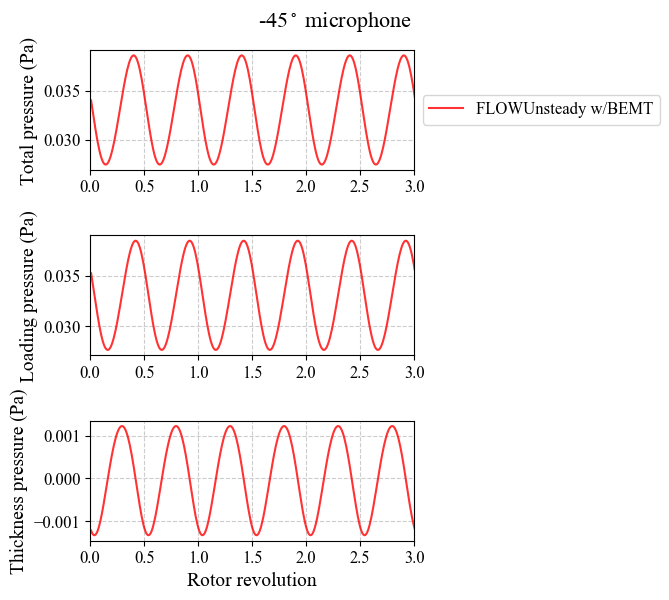

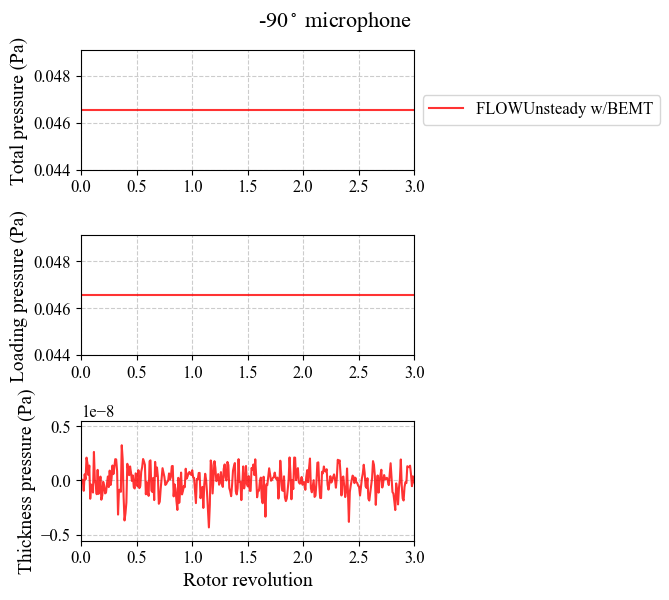

In [8]:
microphones  = [-45, -90]            # (deg) microphones to plot

noise.plot_pressure(dataset_infos, microphones, RPM, sph_ntht, pangle; datasets_psw=datasets_psw)

### SPL Spectrum

Here we compare the SPL spectrum at the microphone $-45^\circ$ below the plane of rotation with the experimental data reported by Zawodny, N. S., & Boyd, Jr., D. D., (2016), *Acoustic Characterization and Prediction of Representative, Small-scale Rotary-wing Unmanned Aircraft System Components*.

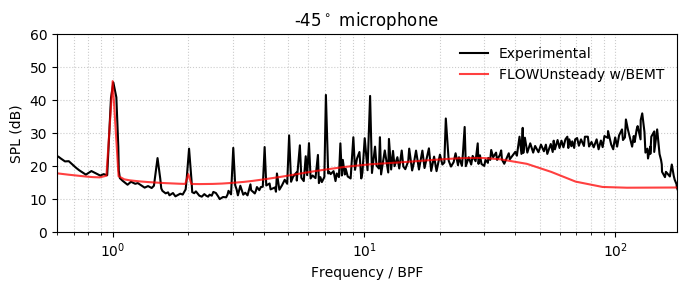

In [84]:
microphone   = -45                   # (deg) microphone to plot
RPM          = 5400                  # RPM of solution
BPF          = 2*RPM/60              # Blade passing frequency

fieldname    = "spl_spectrum"        # Field to plot
mici         = -microphone .+ 181    # Index of each microphone


figure(figsize=[7, 3])

# Plot experimental data from Zawodny et al., Fig. 9
data = CSV.read(joinpath("data", "zawodnydigitization2","zawodny_dji9443_spl_5400_01.csv"))
plot(data[!, 1]/BPF, data[!, 2], "-", label="Experimental", color="k")

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    xi = data_psw["hs"]["Frequency"]
    yi = data_psw["hs"]["Total_dB"]
    freqs_psw = data_psw["field"][mici, 1, 2:end, xi]
    spl_psw = data_psw["field"][mici, 1, 2:end, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    org_spl_bpm = data_bpm["field"][:, mici]
    
    # Define the range of frequency as the union of both components
    freqs = freqs_psw                       # Grab PSW frequency range
    if freqs_psw[end] < freq_bins_bpm[end]  # Add BPM range
        bpm_i = findfirst( f -> f > freqs_psw[end], freq_bins_bpm)
        freqs = vcat(freqs, freq_bins_bpm[bpm_i:end])
        spl_psw = vcat(spl_psw, [-30.0 for i in bpm_i:length(freq_bins_bpm)])
    end
    
    # Interpolate broadband data into the same frequencies than tonal data
    spl_bpm = math.akima(freq_bins_bpm, org_spl_bpm, freqs)
    
    # Add tonal and broadband SPL together
    spl = noise.addSPL(spl_psw, spl_bpm)

    plot(freqs/BPF, spl,  stl, alpha=0.75, label=lbl, color=clr)

end

title("$(Int(round(pangle(mici))))"*L"$^\circ$ microphone")
xlim([6*10.0^(-1.0), 1.75e2])
xscale("log")
xlabel("Frequency / BPF")
ylim([0, 60])
ylabel("SPL (dB)")
PyPlot.grid(true, which="major", color="0.8", linestyle=":")
PyPlot.grid(true, which="minor", color="0.8", linestyle=":")
legend(loc="best", frameon=false)

tight_layout()

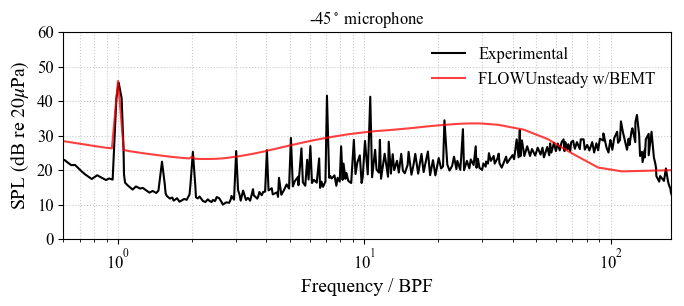

In [14]:
microphones  = [-45]                 # (deg) microphone to plot
Aweighted    = false                 # Plot A-weighted SPL

# Experimental data from Zawodny et al., Fig. 9
filename = joinpath("data", "zawodnydigitization2", "zawodny_dji9443_spl_5400_01.csv")
plot_experimental = [(filename, "Experimental", "k", Aweighted, [])]

# Plot spectrum in Hz with blade-passing-frequency lines
noise.plot_spectrum_spl(dataset_infos, microphones, BPF, sph_ntht, pangle; 
                          datasets_psw=datasets_psw, datasets_bpm=datasets_bpm,
                          Aweighted=Aweighted,
                          plot_csv=plot_experimental)

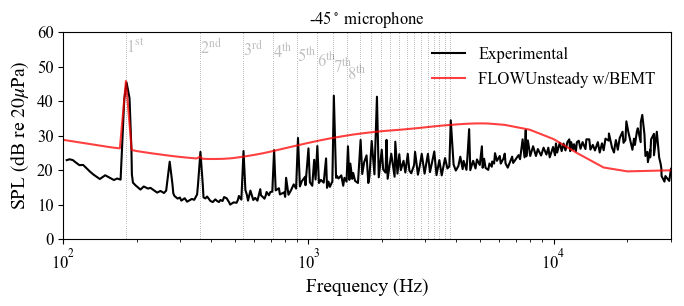

In [10]:
# Plot spectrum in Hz with blade-passing-frequency lines
noise.plot_spectrum_spl(dataset_infos, microphones, BPF, sph_ntht, pangle; 
                          datasets_psw=datasets_psw, datasets_bpm=datasets_bpm,
                          Aweighted=Aweighted,
                          plot_csv=plot_experimental, 
                          xBPF=false, xlims=[100, 3e4], BPF_lines=21)

### A-weighted SPL Spectrum

Same than previous plot, but A-weighted.

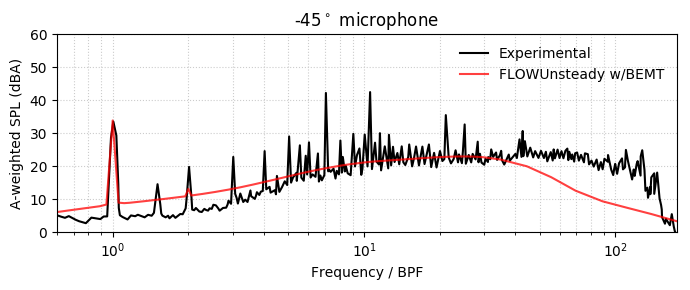

In [85]:
microphone   = -45                   # (deg) microphone to plot
RPM          = 5400                  # RPM of solution
BPF          = 2*RPM/60              # Blade passing frequency

fieldname    = "spl_spectrum"        # Field to plot
mici         = -microphone .+ 181   # Index of every microphone


figure(figsize=[7, 3])

# Plot experimental data from Zawodny et al., Fig. 9
data = CSV.read(joinpath("data", "zawodnydigitization2","zawodny_dji9443_spl_5400_01.csv"))
splA_exp = noise.aWeight.(data[!, 1], data[!, 2])
plot(data[!, 1]/BPF, splA_exp, "-", label="Experimental", color="k")

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    xi = data_psw["hs"]["Frequency"]
    yi = data_psw["hs"]["Total_dBA"]
    freqs_psw = data_psw["field"][mici, 1, 2:end, xi]
    spl_psw = data_psw["field"][mici, 1, 2:end, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl]["splA_spectrum"]
    org_spl_bpm = data_bpm["field"][:, mici]
    
    # Define the range of frequency as the union of both components
    freqs = freqs_psw                       # Grab PSW frequency range
    if freqs_psw[end] < freq_bins_bpm[end]  # Add BPM range
        bpm_i = findfirst( f -> f > freqs_psw[end], freq_bins_bpm)
        freqs = vcat(freqs, freq_bins_bpm[bpm_i:end])
        spl_psw = vcat(spl_psw, [-30.0 for i in bpm_i:length(freq_bins_bpm)])
    end
    
    # Interpolate broadband data into the same frequencies than tonal data
    spl_bpm = math.akima(freq_bins_bpm, org_spl_bpm, freqs)
    
    # Add tonal and broadband SPL together
    spl = noise.addSPL(spl_psw, spl_bpm)

    plot(freqs/BPF, spl,  stl, alpha=0.75, label=lbl, color=clr)

end

title("$(Int(round(pangle(mici))))"*L"$^\circ$ microphone")
xlim([6*10.0^(-1.0), 1.75e2])
xscale("log")
xlabel("Frequency / BPF")
ylim([0, 60])
ylabel("A-weighted SPL (dBA)")
PyPlot.grid(true, which="major", color="0.8", linestyle=":")
PyPlot.grid(true, which="minor", color="0.8", linestyle=":")
legend(loc="best", frameon=false)

tight_layout()

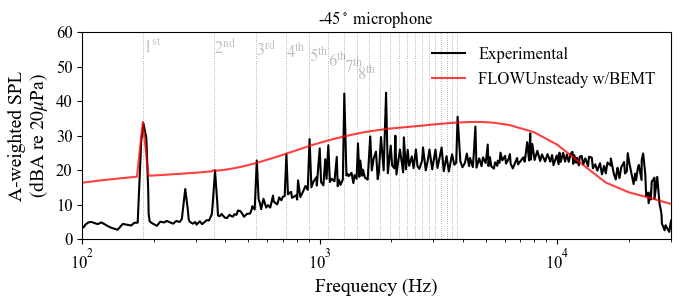

In [12]:
microphones  = [-45]                 # (deg) microphone to plot
Aweighted    = true                  # Plot A-weighted SPL

# Experimental data from Zawodny et al., Fig. 9
filename = joinpath("data", "zawodnydigitization2", "zawodny_dji9443_spl_5400_01.csv")
plot_experimental = [(filename, "Experimental", "k", Aweighted, [])]

# Plot spectrum in Hz with blade-passing-frequency lines
noise.plot_spectrum_spl(dataset_infos, microphones, BPF, sph_ntht, pangle; 
                          datasets_psw=datasets_psw, datasets_bpm=datasets_bpm,
                          Aweighted=Aweighted,
                          plot_csv=plot_experimental, 
                          xBPF=false, xlims=[100, 3e4], BPF_lines=21)

### Tonal Directivity &ndash; First BPF

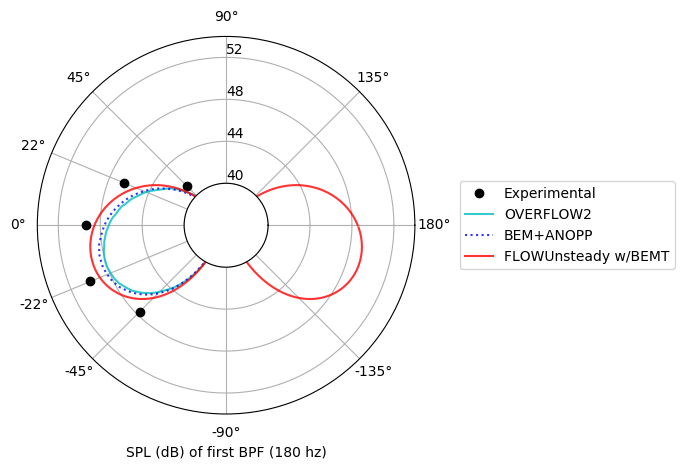

In [44]:
BPFi         = 1                     # BPF multiple to plot
RPM          = 5400                  # RPM of solution
BPF          = 2*RPM/60              # Blade passing frequency

fieldname    = "spl_spectrum"        # Field to plot

# Plot experimental and computational data reported by Zawodny et al., Fig. 14
data_exp = CSV.read(joinpath("data", "zawodnydigitization2",
                                        "zawodny_fig14_topright_exp00.csv"), datarow=1)
data_of = CSV.read(joinpath("data",  "zawodnydigitization2",
                                        "zawodny_fig14_topright_of00.csv"), datarow=1)
data_pas = CSV.read(joinpath("data", "zawodnydigitization2",
                                        "zawodny_fig14_topright_pas00.csv"), datarow=1)

polar(pi/180*data_exp[!, 2], data_exp[!, 1], "o", label="Experimental", color="k")
polar(pi/180*data_of[!, 2], data_of[!, 1], "-", label="OVERFLOW2", alpha=0.8, color="c")
polar(pi/180*data_pas[!, 2], data_pas[!, 1], ":b", label="BEM+ANOPP", alpha=0.8)

# Grab angles
pointangles = pangle.(1:grid.nnodes)

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    yi = data_psw["hs"]["Total_dB"]
    fi = data_psw["hs"]["Frequency"]
    
    df = data_psw["field"][1, 1, 2, fi] - data_psw["field"][1, 1, 1, fi] # Frequency step
    freqi = ceil(Int, BPFi*BPF/df + 1)                           # Frequency index
    freq = data_psw["field"][1, 1, freqi, fi]                    # Frequency
    # _lbl = " @ $(data_psw["field"][1, 1, freqi, fi]) Hz"         # Frequency string
    _lbl = ""
    
    spl_psw = data_psw["field"][:, 1, freqi, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    spl_bpm = [math.akima(freq_bins_bpm, data_bpm["field"][:, mici], freq) for mici in 1:grid.nnodes]
    
    # Add tonal and broadband SPL together
    spl = noise.addSPL(spl_psw, spl_bpm)
    
    
    polar(pi/180*pointangles, spl, stl, label=lbl*_lbl, alpha=0.8, color=clr)
end

ax = gca()
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_thetalim(pi/180*180*[1, -1])
ax.set_rlabel_position(90)
ax.set_rticks(40:4:52)
ax.set_rlim([40, 54])
ax.set_rorigin(36)
ax.set_thetagrids(collect(-180:45/2:180)[[3, 5, 7, 8, 9, 10, 11, 13, 15, 17]])
ax.grid(true)
xlabel("SPL (dB) of first BPF ($(ceil(Int, BPFi*BPF)) hz)")
legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
tight_layout();

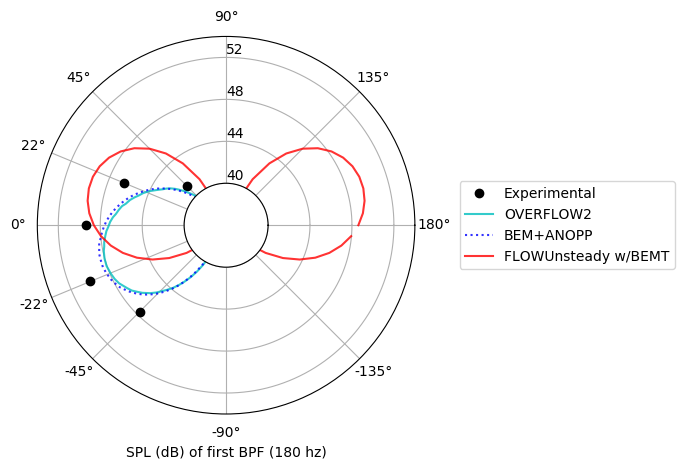

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = ip:0x0
└ @ Core :-1


In [39]:
BPFi         = 1                     # BPF multiple to plot
RPM          = 5400                  # RPM of solution
BPF          = 2*RPM/60              # Blade passing frequency

fieldname    = "spl_spectrum"        # Field to plot

# Plot experimental and computational data reported by Zawodny et al., Fig. 14
data_exp = CSV.read(joinpath("data", "zawodnydigitization2",
                                        "zawodny_fig14_topright_exp00.csv"), datarow=1)
data_of = CSV.read(joinpath("data",  "zawodnydigitization2",
                                        "zawodny_fig14_topright_of00.csv"), datarow=1)
data_pas = CSV.read(joinpath("data", "zawodnydigitization2",
                                        "zawodny_fig14_topright_pas00.csv"), datarow=1)

polar(pi/180*data_exp[!, 2], data_exp[!, 1], "o", label="Experimental", color="k")
polar(pi/180*data_of[!, 2], data_of[!, 1], "-", label="OVERFLOW2", alpha=0.8, color="c")
polar(pi/180*data_pas[!, 2], data_pas[!, 1], ":b", label="BEM+ANOPP", alpha=0.8)

# Grab angles
pointangles = pangle.(1:grid.nnodes)

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    yi = data_psw["hs"]["Total_dB"]
    fi = data_psw["hs"]["Frequency"]
    
    df = data_psw["field"][1, 1, 2, fi] - data_psw["field"][1, 1, 1, fi] # Frequency step
    freqi = ceil(Int, BPFi*BPF/df + 1)                           # Frequency index
    freq = data_psw["field"][1, 1, freqi, fi]                    # Frequency
    # _lbl = " @ $(data_psw["field"][1, 1, freqi, fi]) Hz"         # Frequency string
    _lbl = ""
    
    spl_psw = data_psw["field"][:, 1, freqi, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    spl_bpm = [math.akima(freq_bins_bpm, data_bpm["field"][:, mici], freq) for mici in 1:grid.nnodes]
    
    # Add tonal and broadband SPL together
    spl = noise.addSPL(spl_psw, spl_bpm)
    
    
    polar(pi/180*pointangles, spl, stl, label=lbl*_lbl, alpha=0.8, color=clr)
end

ax = gca()
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_thetalim(pi/180*180*[1, -1])
ax.set_rlabel_position(90)
ax.set_rticks(40:4:52)
ax.set_rlim([40, 54])
ax.set_rorigin(36)
ax.set_thetagrids(collect(-180:45/2:180)[[3, 5, 7, 8, 9, 10, 11, 13, 15, 17]])
ax.grid(true)
xlabel("SPL (dB) of first BPF ($(ceil(Int, BPFi*BPF)) hz)")
legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
tight_layout();

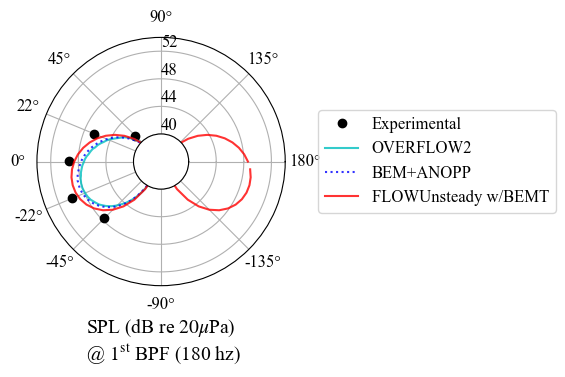

In [36]:
BPFi = 1                 # Multiple of blade-passing frequency to plot

# Experimental and computational data reported by Zawodny et al., Fig. 14
filename1 = joinpath("data", "zawodnydigitization2", "zawodny_fig14_topright_exp00.csv")
filename2 = joinpath("data", "zawodnydigitization2", "zawodny_fig14_topright_of00.csv")
filename3 = joinpath("data", "zawodnydigitization2", "zawodny_fig14_topright_pas00.csv")

plot_experimental = [(filename1, "Experimental", "ok", Aweighted, []),
                     (filename2, "OVERFLOW2", "-c", Aweighted, [(:alpha, 0.8)]),
                     (filename3, "BEM+ANOPP", ":b", Aweighted, [(:alpha, 0.8)])]

# Plot SPL directivity of first blade-passing frequency
noise.plot_directivity_splbpf(dataset_infos, BPFi, BPF, pangle;
                                    datasets_psw=datasets_psw,
                                    datasets_bpm=datasets_bpm,
                                    plot_csv=plot_experimental,
                                    rticks=40:4:52, rlims=[40, 54], rorigin=36)

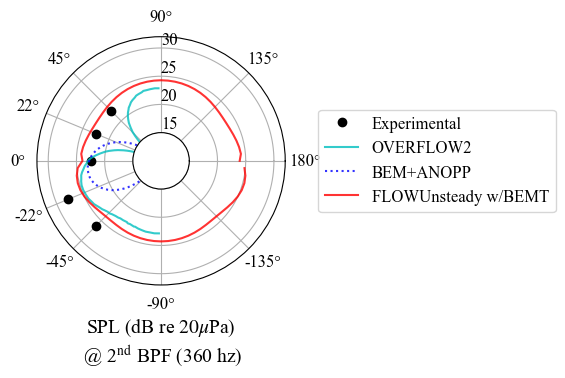

In [38]:
BPFi = 2                 # Multiple of blade-passing frequency to plot

# Experimental and computational data reported by Zawodny et al., Fig. 14
filename1 = joinpath("data", "zawodnydigitization2", "zawodny_fig14_bottomright_exp00.csv")
filename2 = joinpath("data", "zawodnydigitization2", "zawodny_fig14_bottomright_of00.csv")
filename3 = joinpath("data", "zawodnydigitization2", "zawodny_fig14_bottomright_pas00.csv")

plot_experimental = [(filename1, "Experimental", "ok", Aweighted, []),
                     (filename2, "OVERFLOW2", "-c", Aweighted, [(:alpha, 0.8)]),
                     (filename3, "BEM+ANOPP", ":b", Aweighted, [(:alpha, 0.8)])]

# Plot SPL directivity of first blade-passing frequency
noise.plot_directivity_splbpf(dataset_infos, BPFi, BPF, pangle;
                                    datasets_psw=datasets_psw,
                                    datasets_bpm=datasets_bpm,
                                    plot_csv=plot_experimental,
                                    rticks=15:5:30, rlims=[15, 32], rorigin=10)

### Tonal Directivity &ndash; Second BPF

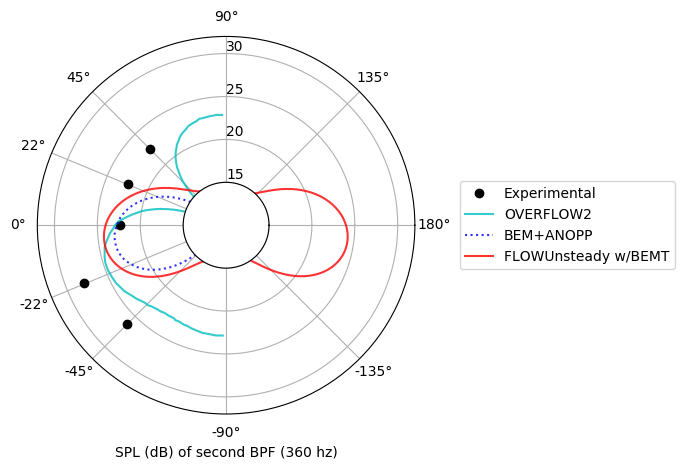

In [49]:
BPFi         = 2                     # BPF multiple to plot
RPM          = 5400                  # RPM of solution
BPF          = 2*RPM/60              # Blade passing frequency

fieldname    = "spl_spectrum"        # Field to plot

# Plot experimental and computational data reported by Zawodny et al., Fig. 14
data_exp = CSV.read(joinpath("data", "zawodnydigitization2",
                                        "zawodny_fig14_bottomright_exp00.csv"), datarow=1)
data_of = CSV.read(joinpath("data",  "zawodnydigitization2",
                                        "zawodny_fig14_bottomright_of00.csv"), datarow=1)
data_pas = CSV.read(joinpath("data", "zawodnydigitization2",
                                        "zawodny_fig14_bottomright_pas00.csv"), datarow=1)

polar(pi/180*data_exp[!, 2], data_exp[!, 1], "o", label="Experimental", color="k")
polar(pi/180*data_of[!, 2], data_of[!, 1], "-", label="OVERFLOW2", alpha=0.8, color="c")
polar(pi/180*data_pas[!, 2], data_pas[!, 1], ":b", label="BEM+ANOPP", alpha=0.8)

# Grab angles
pointangles = pangle.(1:grid.nnodes)

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    yi = data_psw["hs"]["Total_dB"]
    fi = data_psw["hs"]["Frequency"]
    
    df = data_psw["field"][1, 1, 2, fi] - data_psw["field"][1, 1, 1, fi] # Frequency step
    freqi = ceil(Int, BPFi*BPF/df + 1)                           # Frequency index
    freq = data_psw["field"][1, 1, freqi, fi]                    # Frequency
    # _lbl = " @ $(data_psw["field"][1, 1, freqi, fi]) Hz"         # Frequency string
    _lbl = ""
    
    spl_psw = data_psw["field"][:, 1, freqi, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    spl_bpm = [math.akima(freq_bins_bpm, data_bpm["field"][:, mici], freq) for mici in 1:grid.nnodes]
    
    # Add tonal and broadband SPL together
    spl = noise.addSPL(spl_psw, spl_bpm)
    
    
    polar(pi/180*pointangles, spl, stl, label=lbl*_lbl, alpha=0.8, color=clr)
end

ax = gca()
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_thetalim(pi/180*180*[1, -1])
ax.set_rlabel_position(90)
ax.set_rticks(15:5:30)
ax.set_rlim([15, 32])
ax.set_rorigin(10)
ax.set_thetagrids(collect(-180:45/2:180)[[3, 5, 7, 8, 9, 10, 11, 13, 15, 17]])
ax.grid(true)
xlabel("SPL (dB) of second BPF ($(ceil(Int, BPFi*BPF)) hz)")
legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
tight_layout();

### Overall SPL Directivity

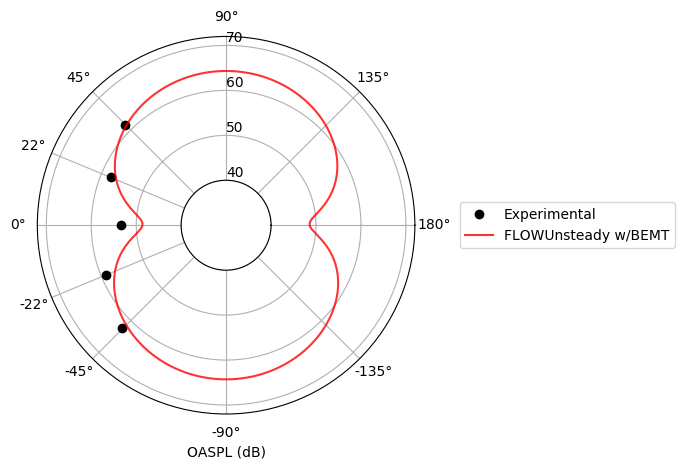

In [72]:
fieldname    = "OASPLdB"        # Field to plot

# Plot experimental data reported by Zawodny et al., Fig. 12
data_exp = CSV.read(joinpath("data", "zawodnydigitization2",
                                        "zawodny_fig12_left_5400_00.csv"), datarow=1)
polar(pi/180*data_exp[!, 2], data_exp[!, 1], "ok", label="Experimental")

# Grab angles
pointangles = pangle.(1:grid.nnodes)

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    yi = data_psw["hs"]["TotalOASPLdB"]
    oaspl_psw = data_psw["field"][:, 1, 1, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    oaspl_bpm = data_bpm["field"][:]
    
    # Add tonal and broadband OASPL together
    oaspl = noise.addSPL(oaspl_psw, oaspl_bpm)
    
    polar(pi/180*pointangles, oaspl, stl, label=lbl, alpha=0.8, color=clr)
end

ax = gca()
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_thetalim(pi/180*180*[1, -1])
ax.set_rlabel_position(90)
ax.set_rticks(40:10:70)
ax.set_rlim([40, 72])
ax.set_rorigin(30)
ax.set_thetagrids(collect(-180:45/2:180)[[3, 5, 7, 8, 9, 10, 11, 13, 15, 17]])
ax.grid(true)
xlabel("OASPL (dB)")
legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
tight_layout();

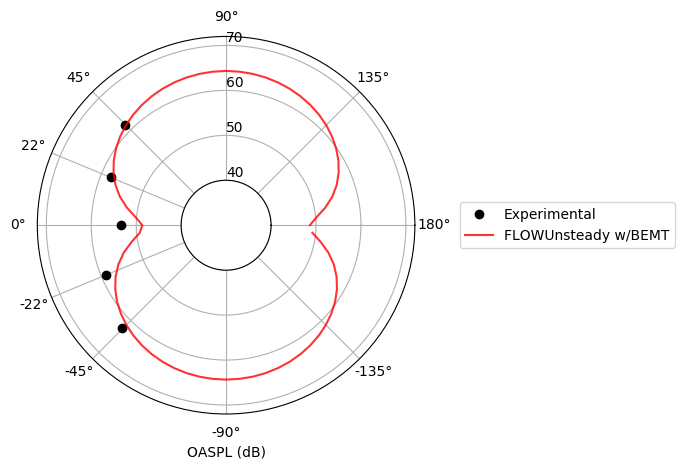

In [42]:
fieldname    = "OASPLdB"        # Field to plot

# Plot experimental data reported by Zawodny et al., Fig. 12
data_exp = CSV.read(joinpath("data", "zawodnydigitization2",
                                        "zawodny_fig12_left_5400_00.csv"), datarow=1)
polar(pi/180*data_exp[!, 2], data_exp[!, 1], "ok", label="Experimental")

# Grab angles
pointangles = pangle.(1:grid.nnodes)

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    yi = data_psw["hs"]["TotalOASPLdB"]
    oaspl_psw = data_psw["field"][:, 1, 1, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    oaspl_bpm = data_bpm["field"][:]
    
    # Add tonal and broadband OASPL together
    oaspl = noise.addSPL(oaspl_psw, oaspl_bpm)
    
    polar(pi/180*pointangles, oaspl, stl, label=lbl, alpha=0.8, color=clr)
end

ax = gca()
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_thetalim(pi/180*180*[1, -1])
ax.set_rlabel_position(90)
ax.set_rticks(40:10:70)
ax.set_rlim([40, 72])
ax.set_rorigin(30)
ax.set_thetagrids(collect(-180:45/2:180)[[3, 5, 7, 8, 9, 10, 11, 13, 15, 17]])
ax.grid(true)
xlabel("OASPL (dB)")
legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
tight_layout();

### A-weighted Overall SPL Directivity

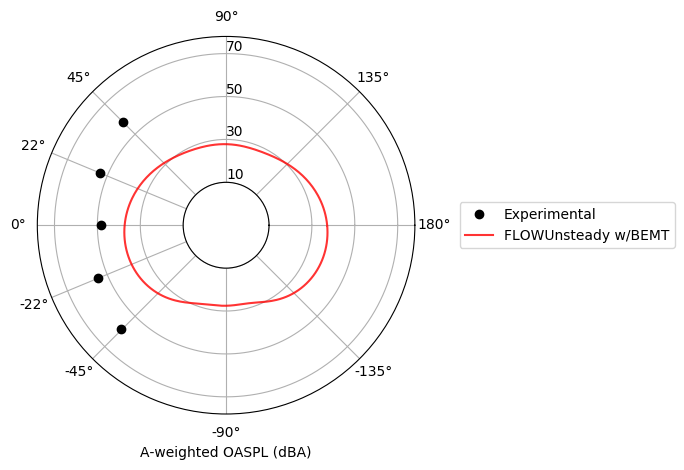

In [80]:
fieldname    = "OASPLdBA"        # Field to plot

# Plot experimental data reported by Zawodny et al., Fig. 12
data_exp = CSV.read(joinpath("data", "zawodnydigitization2",
                                        "zawodny_fig12_right_5400_00.csv"), datarow=1)
polar(pi/180*data_exp[!, 2], data_exp[!, 1], "ok", label="Experimental")

# Grab angles
pointangles = pangle.(1:grid.nnodes)

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    yi = data_psw["hs"]["TotalOASPLdBA"]
    oaspl_psw = data_psw["field"][:, 1, 1, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    oaspl_bpm = data_bpm["field"][:]
    
    # Add tonal and broadband OASPL together
    oaspl = noise.addSPL(oaspl_psw, oaspl_bpm)
    
    polar(pi/180*pointangles, oaspl, stl, label=lbl, alpha=0.8, color=clr)
end

ax = gca()
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_thetalim(pi/180*180*[1, -1])
ax.set_rlabel_position(90)
ax.set_rticks(10:20:70)
ax.set_rlim([10, 78])
ax.set_rorigin(-10)
ax.set_thetagrids(collect(-180:45/2:180)[[3, 5, 7, 8, 9, 10, 11, 13, 15, 17]])
ax.grid(true)
xlabel("A-weighted OASPL (dBA)")
legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
tight_layout();

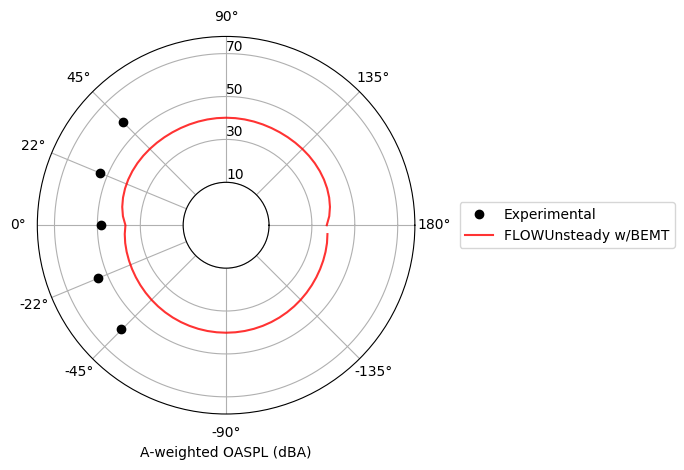

In [43]:
fieldname    = "OASPLdBA"        # Field to plot

# Plot experimental data reported by Zawodny et al., Fig. 12
data_exp = CSV.read(joinpath("data", "zawodnydigitization2",
                                        "zawodny_fig12_right_5400_00.csv"), datarow=1)
polar(pi/180*data_exp[!, 2], data_exp[!, 1], "ok", label="Experimental")

# Grab angles
pointangles = pangle.(1:grid.nnodes)

# Plot datasets
for (lbl, _, _, freq_bins_bpm, stl, clr) in dataset_infos

    # Fetch tonal noise
    data_psw = datasets_psw[lbl][fieldname]
    yi = data_psw["hs"]["TotalOASPLdBA"]
    oaspl_psw = data_psw["field"][:, 1, 1, yi]
    
    # Fetch broadband noise
    data_bpm = datasets_bpm[lbl][fieldname]
    oaspl_bpm = data_bpm["field"][:]
    
    # Add tonal and broadband OASPL together
    oaspl = noise.addSPL(oaspl_psw, oaspl_bpm)
    
    polar(pi/180*pointangles, oaspl, stl, label=lbl, alpha=0.8, color=clr)
end

ax = gca()
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_thetalim(pi/180*180*[1, -1])
ax.set_rlabel_position(90)
ax.set_rticks(10:20:70)
ax.set_rlim([10, 78])
ax.set_rorigin(-10)
ax.set_thetagrids(collect(-180:45/2:180)[[3, 5, 7, 8, 9, 10, 11, 13, 15, 17]])
ax.grid(true)
xlabel("A-weighted OASPL (dBA)")
legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
tight_layout();